In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from scipy.optimize import curve_fit


In [3]:
df = pd.read_csv("./data/wholetime.csv")
df.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [4]:
# Get the node_list, edge_list and timestamp
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [5]:
# データセットをいくつかのグループに分ける
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()

node_list_p1, edge_list_p1, timestamp_p1 = return_nm(df_p1)
node_list_p2, edge_list_p2, timestamp_p2 = return_nm(df_p2)
node_list_p3, edge_list_p3, timestamp_p3 = return_nm(df_p3)
node_list_p4, edge_list_p4, timestamp_p4 = return_nm(df_p4)

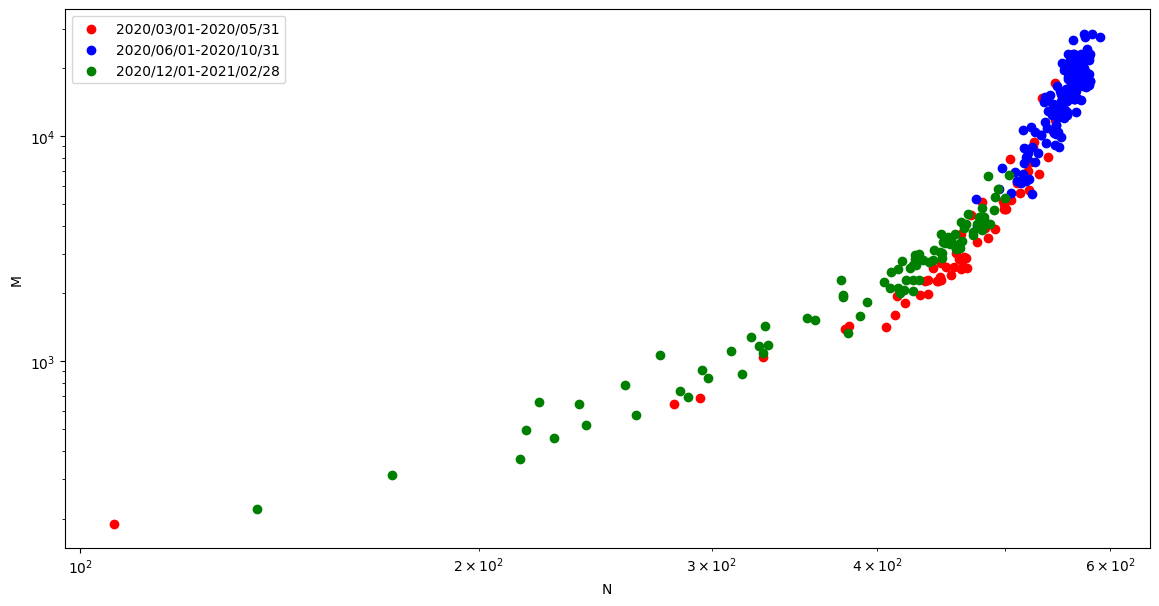

In [7]:
# color
color_list = ['red', 'blue', 'green', 'orange']

plt.figure(figsize=(14, 7))
plt.scatter(node_list_p1, edge_list_p1, label='2020/03/01-2020/05/31', color=color_list[0])
plt.scatter(node_list_p2, edge_list_p2, label='2020/06/01-2020/10/31', color=color_list[1])
plt.scatter(node_list_p3, edge_list_p3, label='2020/12/01-2021/02/28', color=color_list[2])
# plt.scatter(node_list_p4, edge_list_p4, label='2021/03/01-2023/9/30', color=color_list[3])
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [8]:
df_p1_p2_p3 = pd.concat([df_p1, df_p2, df_p3])
node_list_p1_p2_p3, edge_list_p1_p2_p3, timestamp_p1_p2_p3 = return_nm(df_p1_p2_p3)

In [9]:
"""
Kobayashi & Génois (2021)のモデルを用いて、計算する
"""
def model1(m, m0, kappa):
    Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2
    res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
    if res.any() < 0:
        return 0
    else:
        return res
    
def model2(m, m0, Np):
    kappa = 8*m0/(Np**2-Np)
    res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))
    if res.any() < 0:
        return 0
    else:
        return res
    
def calc_N(Np, kappa):
    return Np * (1 - (2 / (kappa * Np))*(1 - (1 - (kappa / 2))**Np))

def calc_M(Np, kappa):
    return (kappa * Np * (Np - 1)) / 8

In [11]:
"""model1
推定する
"""
init_m0_range = [1, 300]
init_kappa_range = [0.01, 1.05]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(1000):
    init_m0 = np.random.uniform(*init_m0_range)
    init_kappa = np.random.uniform(*init_kappa_range)
    

    popt, pcov = curve_fit(model1, edge_list_p1_p2_p3, node_list_p1_p2_p3, p0=[init_m0, init_kappa])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_p1_p2_p3 - model1(edge_list_p1_p2_p3, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
m0_init = best_fit[0]
kappa_init = best_fit[1]

[4.17717431e+03 1.31333724e-01]


In [12]:
"""model2
推定する
"""
# 初期値を探す for model2
# 初期値の範囲を設定
init_m0_range = [1, 40000]
init_Np_range = [1, 10000]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range)
    init_Np = np.random.uniform(*init_Np_range)
    

    popt, pcov = curve_fit(model1, edge_list_p1_p2_p3, node_list_p1_p2_p3, p0=[init_m0, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_p1_p2_p3 - model2(edge_list_p1_p2_p3, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

[15058.95091207   520.65365416]


In [13]:
N_fit = []
M_fit = []
popt, pcov = curve_fit(model1,edge_list_p1_p2_p3,node_list_p1_p2_p3,p0=[m0_init, kappa_init])
print("model1: ", popt)

Np = []
kappa = popt[1]
for i in range(len(edge_list_p1_p2_p3)):
    Np.append((1+np.sqrt(1+32*edge_list_p1_p2_p3[i]/kappa))/2)


for i in range(len(node_list_p1_p2_p3)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(edge_list_p1_p2_p3)):
    M_fit.append(calc_M(Np[i], kappa))

model1:  [4.17717431e+03 1.31333724e-01]


In [14]:
N_fit2 = []
M_fit2 = []
popt2, pcov2 = curve_fit(model2, edge_list_p1_p2_p3, node_list_p1_p2_p3, p0=[m0_init2, Np_init2])
print("model2: ", popt2)
Np2 = popt2[1]
kappa2 = []
for i in range(len(edge_list_p1_p2_p3)):
    kappa2.append(8*edge_list_p1_p2_p3[i]/(Np2**2-Np2))

for i in range(len(node_list_p1_p2_p3)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(edge_list_p1_p2_p3)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

model2:  [3311.81446247  509.23549472]


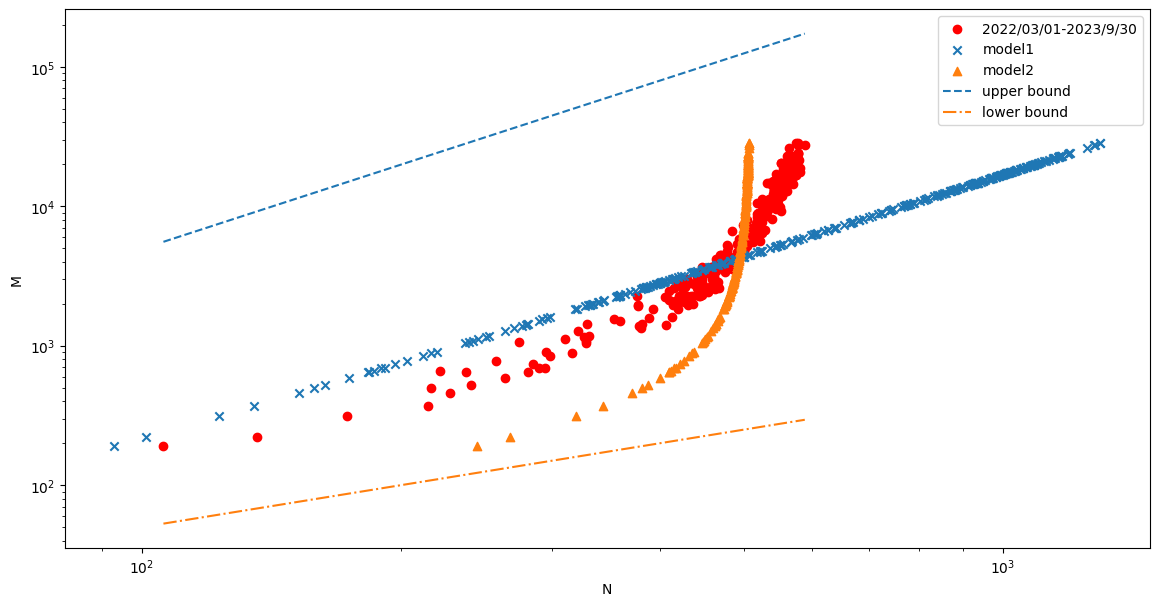

In [15]:
# プロット
nn = len(node_list_p1_p2_p3)
xmin = min(node_list_p1_p2_p3)
xmax = max(node_list_p1_p2_p3)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2



plt.figure(figsize=(14, 7))
plt.scatter(node_list_p1_p2_p3, edge_list_p1_p2_p3, label='2022/03/01-2023/9/30', color=color_list[0])
plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

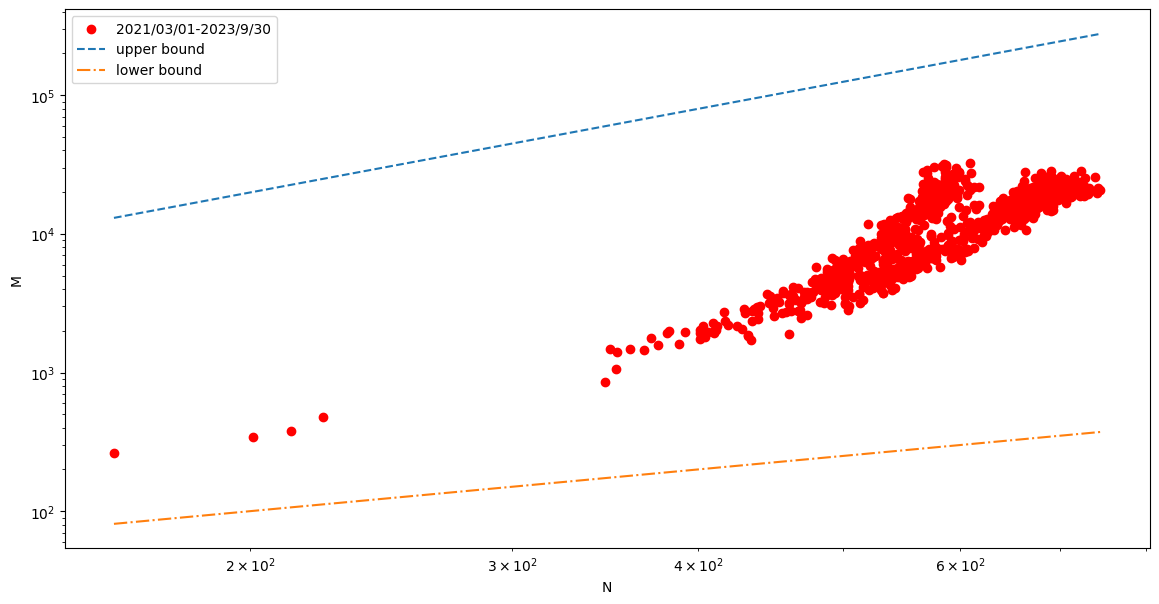

In [22]:
# p4をプロット
plt.figure(figsize=(14, 7))
plt.scatter(node_list_p4, edge_list_p4, label='2021/03/01-2023/9/30', color=color_list[0])
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [17]:
"""model1
推定する
"""
init_m0_range = [1, 300]
init_kappa_range = [0.01, 1.05]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(1000):
    init_m0 = np.random.uniform(*init_m0_range)
    init_kappa = np.random.uniform(*init_kappa_range)
    

    popt, pcov = curve_fit(model1, edge_list_p4, node_list_p4, p0=[init_m0, init_kappa])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_p4 - model1(edge_list_p4, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
m0_init = best_fit[0]
kappa_init = best_fit[1]

[1.89754333e+04 4.35709766e-01]


In [38]:
"""model2
推定する
"""
# 初期値を探す for model2
# 初期値の範囲を設定
init_m0_range = [1, 40000]
init_Np_range = [1, 10000]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range)
    init_Np = np.random.uniform(*init_Np_range)
    

    popt, pcov = curve_fit(model2, edge_list_p4, node_list_p4, p0=[init_m0, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_p4 - model2(edge_list_p4, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

[ 327.26482179 3844.29407156]


In [39]:
N_fit = []
M_fit = []
popt, pcov = curve_fit(model1,edge_list_p4,node_list_p4,p0=[m0_init, kappa_init])
print("model1: ", popt)

Np = []
kappa = popt[1]
for i in range(len(edge_list_p4)):
    Np.append((1+np.sqrt(1+32*edge_list_p4[i]/kappa))/2)


for i in range(len(node_list_p4)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(edge_list_p4)):
    M_fit.append(calc_M(Np[i], kappa))

model1:  [8.54107219e+04 1.98520896e+00]


In [40]:
N_fit2 = []
M_fit2 = []
popt2, pcov2 = curve_fit(model2, edge_list_p4, node_list_p4, p0=[m0_init2, Np_init2])
print("model2: ", popt2)
Np2 = popt2[1]
kappa2 = []
for i in range(len(edge_list_p4)):
    kappa2.append(8*edge_list_p4[i]/(Np2**2-Np2))

for i in range(len(node_list_p4)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(edge_list_p4)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

model2:  [ 327.26482179 3844.29407156]


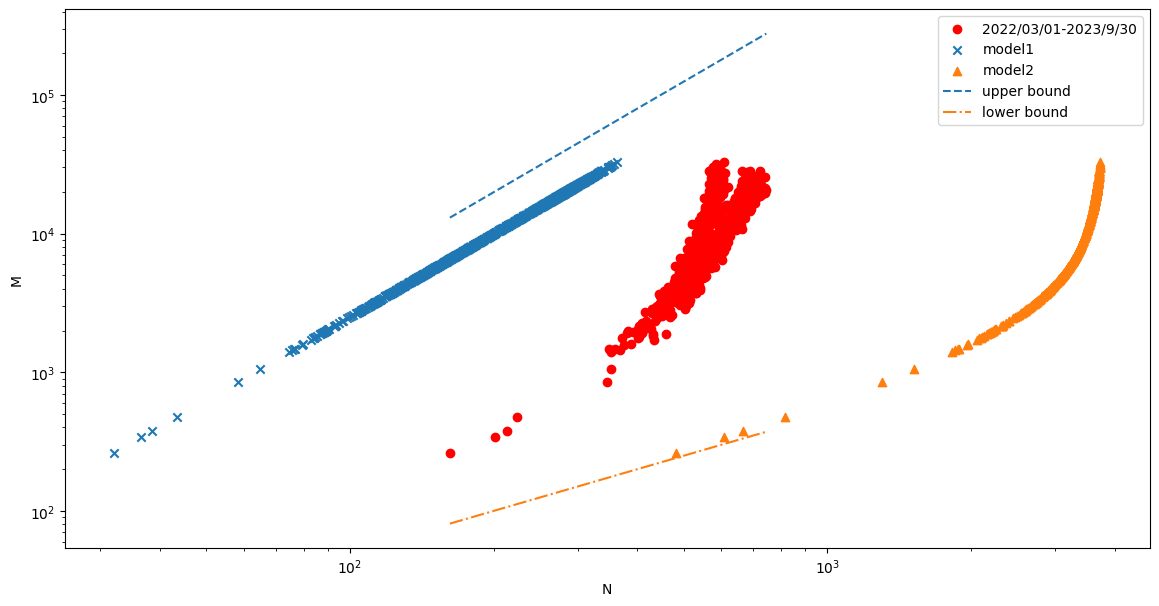

In [41]:
# phase4のプロット
# プロット
nn = len(node_list_p4)
xmin = min(node_list_p4)
xmax = max(node_list_p4)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2



plt.figure(figsize=(14, 7))
plt.scatter(node_list_p4, edge_list_p4, label='2022/03/01-2023/9/30', color=color_list[0])
plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

## df_p4を分析する
df_p4を年単位で区切る

赤：2021年

青：2022年

緑：2023年


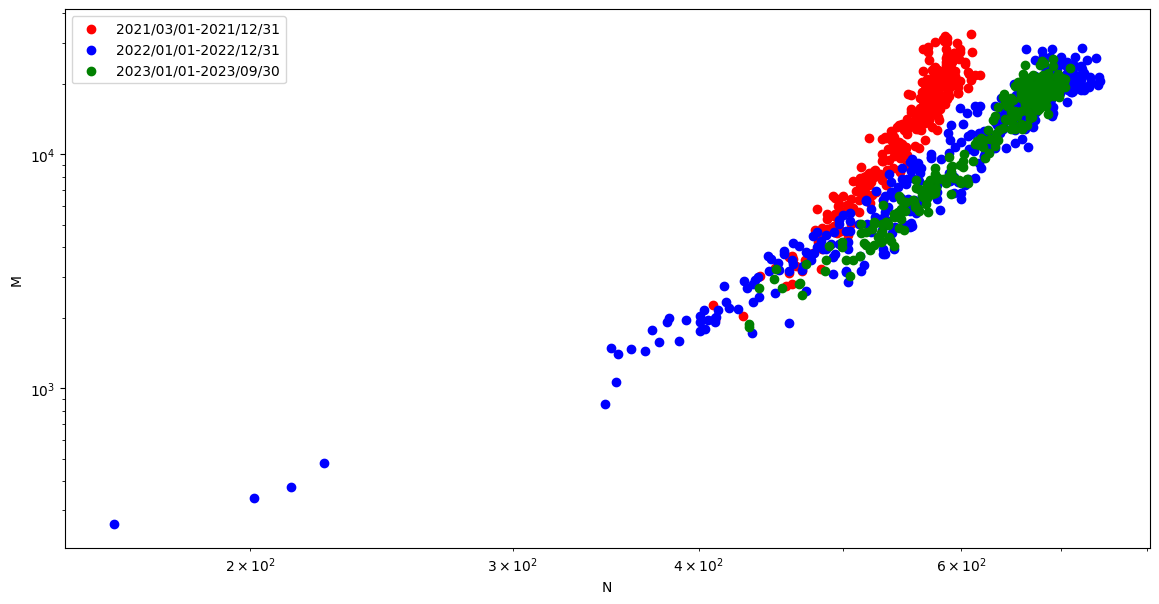

In [23]:
# df_p4を年単位で分割する
color_list = ['red', 'blue', 'green', 'orange']
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-01-01')].dropna()
df_p4_3 = df[(df['started_at'] >= '2023-01-01') & (df['started_at'] < '2024-01-01')].dropna()

# plot
node_list_p4_1, edge_list_p4_1, timestamp_p4_1 = return_nm(df_p4_1)
node_list_p4_2, edge_list_p4_2, timestamp_p4_2 = return_nm(df_p4_2)
node_list_p4_3, edge_list_p4_3, timestamp_p4_3 = return_nm(df_p4_3)

plt.figure(figsize=(14, 7))
plt.scatter(node_list_p4_1, edge_list_p4_1, label='2021/03/01-2021/12/31', color=color_list[0])
plt.scatter(node_list_p4_2, edge_list_p4_2, label='2022/01/01-2022/12/31', color=color_list[1])
plt.scatter(node_list_p4_3, edge_list_p4_3, label='2023/01/01-2023/09/30', color=color_list[2])
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [24]:
# df_p4_1
# df_p4_2とdf_p4_3を結合する
df_p4_2_3 = pd.concat([df_p4_2, df_p4_3])

In [25]:
node_list_p4_2_3, edge_list_p4_2_3, timestamp_p4_2_3 = return_nm(df_p4_2_3)

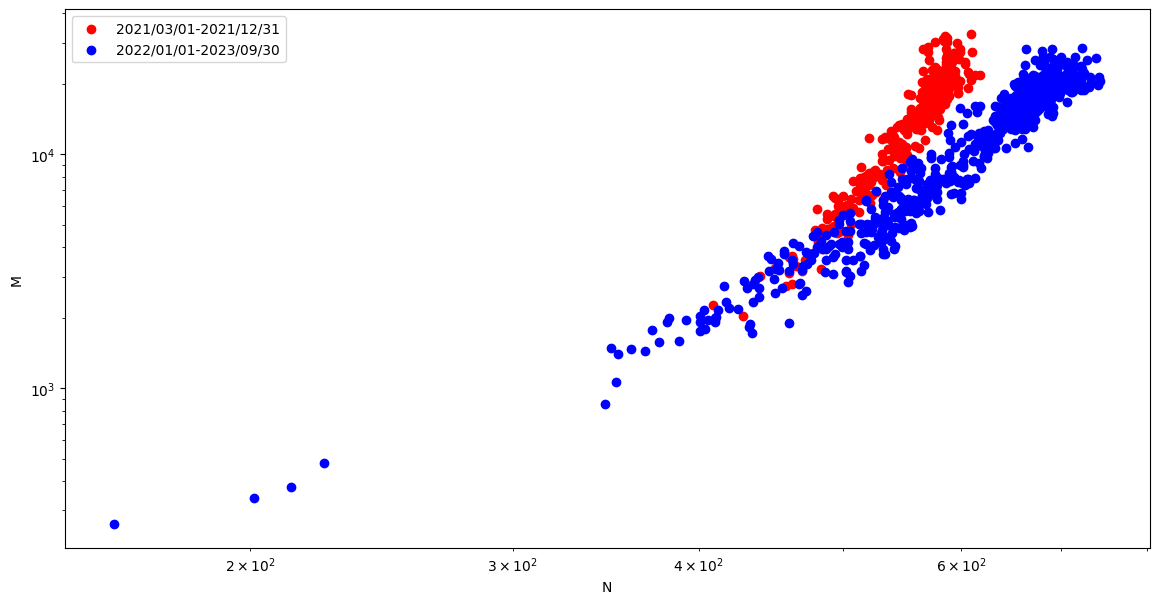

In [26]:
plt.figure(figsize=(14, 7))
plt.scatter(node_list_p4_1, edge_list_p4_1, label='2021/03/01-2021/12/31', color=color_list[0])
plt.scatter(node_list_p4_2_3, edge_list_p4_2_3, label='2022/01/01-2023/09/30', color=color_list[1])
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [32]:
# 赤と青をそれぞれのモデルでフィッティングする
"""model1
推定する
赤バージョン
"""
init_m0_range = [1, 300]
init_kappa_range = [0.01, 1.05]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(1000):
    init_m0 = np.random.uniform(*init_m0_range)
    init_kappa = np.random.uniform(*init_kappa_range)
    

    popt, pcov = curve_fit(model1, edge_list_p4_1, node_list_p4_1, p0=[init_m0, init_kappa])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_p4_1 - model1(edge_list_p4_1, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
m0_init = best_fit[0]
kappa_init = best_fit[1]

[7.45228565e+04 1.96493116e+00]


In [33]:
"""model2
推定する
"""
# 初期値を探す for model2
# 初期値の範囲を設定
init_m0_range = [1, 40000]
init_Np_range = [1, 10000]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range)
    init_Np = np.random.uniform(*init_Np_range)
    

    popt, pcov = curve_fit(model1, edge_list_p4_1, node_list_p4_1, p0=[init_m0, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_p4_1 - model2(edge_list_p4_1, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

[ 284.16313161 4606.64915847]


In [34]:
N_fit = []
M_fit = []
popt, pcov = curve_fit(model1,edge_list_p4_1, node_list_p4_1,p0=[m0_init, kappa_init])
print("model1: ", popt)

Np = []
kappa = popt[1]
for i in range(len(edge_list_p4_1)):
    Np.append((1+np.sqrt(1+32*edge_list_p4_1[i]/kappa))/2)


for i in range(len(node_list_p4_1)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(edge_list_p4_1)):
    M_fit.append(calc_M(Np[i], kappa))

model1:  [7.52667093e+04 1.98461695e+00]


In [35]:
N_fit2 = []
M_fit2 = []
popt2, pcov2 = curve_fit(model2, edge_list_p4_1, node_list_p4_1, p0=[m0_init2, Np_init2])
print("model2: ", popt2)
Np2 = popt2[1]
kappa2 = []
for i in range(len(edge_list_p4_1)):
    kappa2.append(8*edge_list_p4_1[i]/(Np2**2-Np2))

for i in range(len(node_list_p4_1)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(edge_list_p4_1)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

model2:  [ 297.68015435 4943.21505787]


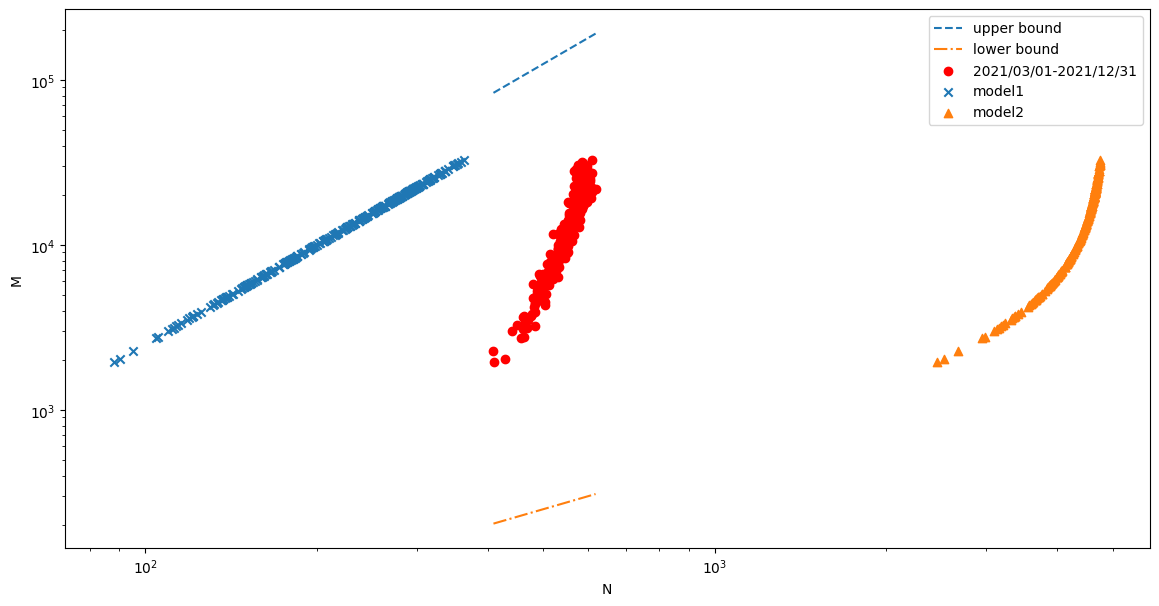

In [37]:
nn = len(node_list_p4_1)
xmin = min(node_list_p4_1)
xmax = max(node_list_p4_1)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2


plt.figure(figsize=(14, 7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.scatter(node_list_p4_1, edge_list_p4_1, label='2021/03/01-2021/12/31', color=color_list[0])
# plt.scatter(node_list_p4_2_3, edge_list_p4_2_3, label='2022/01/01-2023/09/30', color=color_list[1])
plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


## df_p4_2_3を分析する

In [51]:
# 赤と青をそれぞれのモデルでフィッティングする
"""model1
推定する
赤バージョン
"""
init_m0_range = [1, 300]
init_kappa_range = [0.01, 1.05]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(1000):
    init_m0 = np.random.uniform(*init_m0_range)
    init_kappa = np.random.uniform(*init_kappa_range)
    

    popt, pcov = curve_fit(model1, edge_list_p4_2_3, node_list_p4_2_3, p0=[init_m0, init_kappa])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_p4_2_3 - model1(edge_list_p4_2_3, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
m0_init = best_fit[0]
kappa_init = best_fit[1]

[8.93797908e+04 1.96063123e+00]


In [52]:
"""model2
推定する
"""
# 初期値を探す for model2
# 初期値の範囲を設定
init_m0_range2 = [1, 40000]
init_Np_range = [1, 10000]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m02 = np.random.uniform(*init_m0_range2)
    init_Np = np.random.uniform(*init_Np_range)
    

    popt, pcov = curve_fit(model2, edge_list_p4_2_3, node_list_p4_2_3, p0=[init_m02, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_p4_1 - model2(edge_list_p4_1, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

[84513.24389478   581.92347954]


In [53]:
N_fit = []
M_fit = []
popt, pcov = curve_fit(model1,edge_list_p4_2_3, node_list_p4_2_3,p0=[m0_init, kappa_init])
print("model1: ", popt)

Np = []
kappa = popt[1]
for i in range(len(edge_list_p4_2_3)):
    Np.append((1+np.sqrt(1+32*edge_list_p4_2_3[i]/kappa))/2)


for i in range(len(node_list_p4_2_3)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(edge_list_p4_2_3)):
    M_fit.append(calc_M(Np[i], kappa))

model1:  [8.93797908e+04 1.96063123e+00]


In [54]:
N_fit2 = []
M_fit2 = []
popt2, pcov2 = curve_fit(model2, edge_list_p4_2_3, node_list_p4_2_3, p0=[m0_init2, Np_init2])
print("model2: ", popt2)
Np2 = popt2[1]
kappa2 = []
for i in range(len(edge_list_p4_2_3)):
    kappa2.append(8*edge_list_p4_2_3[i]/(Np2**2-Np2))

for i in range(len(node_list_p4_2_3)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(edge_list_p4_2_3)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

model2:  [84513.24389478   581.92347954]


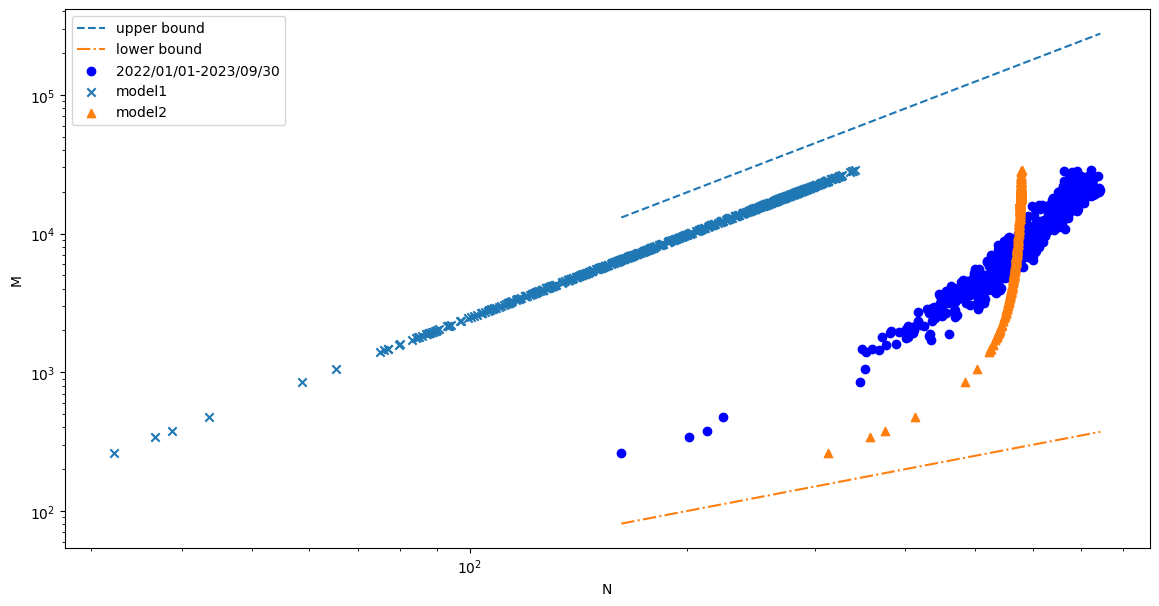

In [55]:
nn = len(node_list_p4_2_3)
xmin = min(node_list_p4_2_3)
xmax = max(node_list_p4_2_3)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2


plt.figure(figsize=(14, 7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.scatter(node_list_p4_2_3, edge_list_p4_2_3, label='2022/01/01-2023/09/30', color=color_list[1])
# plt.scatter(node_list_p4_1, edge_list_p4_1, label='2022/01/01-2023/09/30', color=color_list[1])
plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

## Regime switching
p4が二又になっているので、これを操作することにする

In [56]:
import numpy as np
import pystan
import arviz
import matplotlib.pyplot as plt
import time
import math
import multiprocessing
multiprocessing.set_start_method("fork")

In [66]:
Nv_int = node_list_p4 # no. nodes, D x T  
Mv_int = edge_list_p4 # no. edges, D x T

#---------------------------------------------------------------------------------------------------------------

### NOTE ###: 
#  Make sure that there is no time window exhibiting N=0 and M=0 in between the first and the last windows having N>1. 
#  e.g., OK: [0,0,12,15,19,23,0,0,0], [nan,nan,12,15,19,23,nan,nan,nan].  NG: [0,0,12,15,0,23,0,0,0], [nan,nan,12,15,nan,23,nan,nan,nan].  
#  In this example, the first two zeros (nans) and the last three zeros (nans) will be truncated below. Time windows that exhibit N=0 make it impossible to implement recursive update in the Markov regime switching model.

indday = 0 #the day to be analyzed. 0 ~ D-1

# df_p4のtimebinを計算する
timebin_p4 = []
for i in range(len(timestamp_p4)):
    timebin_p4.append(timestamp_p4[i].strftime('%Y-%m-%d'))
timebin_p4 = np.array(timebin_p4)

nbins = timebin_p4 # no. of timebins
numdays = 943 # no. of days
    
Nv_int[np.isnan(Nv_int)] = 0 #Replace nan with 0
Mv_int[np.isnan(Mv_int)] = 0

Nmin = np.min(Nv_int)# max value
Nmax = np.max(Nv_int)
Mmin = np.min(Mv_int)
Mmax = np.max(Mv_int)
print("Nmin, Nmax, Mmin, Mmax =", Nmin, Nmax, Mmin, Mmax)

Nmin, Nmax, Mmin, Mmax = 162 745 263 32697
